<a href="https://colab.research.google.com/github/stemgene/Predict-Stock-Price-by-LSTM-and-Twitter-Analysis-/blob/master/2_LSTM_on_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import csv
import time
import statistics

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras

import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
stocks = pd.read_csv("/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/SP500_cleaned.csv", parse_dates=['Date']).set_index('Date')
df = stocks.copy()
df.tail()

,price,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,FFT 3,FFT 6,FFT 9,ARIMA
Date,,,,,,,,,,,,,,,,
2019-10-25,3022.550049,3370370000,3003.459996,2964.972366,2976.603905,2991.896296,15.292391,40.567569,3046.107504,2883.837227,3017.565963,3021.550049,2641.9246,2640.4658,2651.7810,3010.628819
2019-10-28,3039.419922,3521230000,3009.384277,2968.669027,2981.256943,2999.207623,17.950680,43.803630,3056.276286,2881.061767,3032.135269,3038.419922,2636.6978,2629.2861,2634.3406,3022.869399
2019-10-29,3036.889893,3589930000,3016.625698,2971.533308,2985.377903,3005.004896,19.626993,45.833728,3063.200764,2879.865852,3035.305018,3035.889893,2631.4626,2618.0781,2616.8286,3040.367206
2019-10-30,3046.770020,3776030000,3022.347133,2976.605690,2989.925467,3011.430299,21.504832,43.989737,3064.585163,2888.626216,3042.948353,3045.770020,2626.2207,2606.8523,2599.2793,3037.673830
2019-10-31,3037.560059,4139280000,3028.285715,2983.746164,2993.453955,3015.450262,21.996307,42.422861,3068.591886,2898.900441,3039.356157,3036.560059,2620.9734,2595.6196,2581.7270,3048.296251


In [0]:
from numpy import genfromtxt
X_train = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/X_train_522_5_39.csv', delimiter=',').reshape(522,5,39)
X_val = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/X_val_115_5_39.csv', delimiter=',').reshape(115,5,39)
X_test = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/X_test_113_5_39.csv', delimiter=',').reshape(113,5,39)
y_train = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/y_train.csv', delimiter=',').reshape(-1,1)
y_val = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/y_val.csv', delimiter=',').reshape(-1,1)
y_test = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/y_test.csv', delimiter=',').reshape(-1,1)
label_level_matrix = genfromtxt('/content/drive/My Drive/UR/DSC440_Data_Mining/Project/Data/trained/label_level_matrix.csv', delimiter=',')
print("X_train's shape:", X_train.shape)
print("y_train's shape:", y_train.shape)
print("X_val's shape:", X_val.shape)
print("y_val's shape:", y_val.shape)
print("X_test's shape:", X_test.shape)
print("y_test's shape:", y_test.shape)

X_train's shape: (522, 5, 39)
y_train's shape: (522, 1)
X_val's shape: (115, 5, 39)
y_val's shape: (115, 1)
X_test's shape: (113, 5, 39)
y_test's shape: (113, 1)


In [0]:
# Basic Cell RNN in tensorflow

index_in_epoch = 0
perm_array = np.arange(X_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
  global index_in_epoch, X_train, perm_array
  start = index_in_epoch
  index_in_epoch += batch_size

  if index_in_epoch > X_train.shape[0]:
    np.random.shuffle(perm_array) # shuffle permutation array
    start = 0 # start nex epoch
    index_in_epoch = batch_size
  
  end = index_in_epoch
  return X_train[perm_array[start:end]], y_train[perm_array[start:end]]

#parameters
seq_len = 5  # choose sequence length
n_steps = seq_len #- 1
n_inputs = 39
n_neurons= 300
n_outputs = 1
n_layers = 2
learning_rate = 0.003
batch_size = 50
n_epochs = 150
train_set_size = X_train.shape[0]
test_set_size = X_test.shape[0]

# setup TensorFlow
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use basic RNN Cell
#layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu) for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu) for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu, use_peepholes = True) for layer in range(n_layers)]

# use GRU cell
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu) for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:, n_steps-1, :] # keep only last output of sequence

loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# run graph
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for iteration in range(int(n_epochs*train_set_size/batch_size)):
    x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
    #print("y_batch is {}".format(y_batch.shape))
    sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
    if iteration % int(5*train_set_size/batch_size) == 0:
      mse_train = loss.eval(feed_dict={X: X_train, y:y_train})
      mse_valid = loss.eval(feed_dict={X: X_val, y:y_val})
      print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train, mse_valid))
  
  y_train_pred = sess.run(outputs, feed_dict={X: X_train})
  y_valid_pred = sess.run(outputs, feed_dict={X: X_val})
  y_test_pred = sess.run(outputs, feed_dict={X: X_test})


0.00 epochs: MSE train/valid = 0.070732/0.072186
4.98 epochs: MSE train/valid = 0.001115/0.003284
9.96 epochs: MSE train/valid = 0.000927/0.002739
14.94 epochs: MSE train/valid = 0.001158/0.002890
19.92 epochs: MSE train/valid = 0.000708/0.002259
24.90 epochs: MSE train/valid = 0.000754/0.002329
29.89 epochs: MSE train/valid = 0.000643/0.002115
34.87 epochs: MSE train/valid = 0.000466/0.001745
39.85 epochs: MSE train/valid = 0.000419/0.001664
44.83 epochs: MSE train/valid = 0.000374/0.001761
49.81 epochs: MSE train/valid = 0.000466/0.001992
54.79 epochs: MSE train/valid = 0.000287/0.001546
59.77 epochs: MSE train/valid = 0.000284/0.001439
64.75 epochs: MSE train/valid = 0.000322/0.001514
69.73 epochs: MSE train/valid = 0.000237/0.001449
74.71 epochs: MSE train/valid = 0.000441/0.001982
79.69 epochs: MSE train/valid = 0.000310/0.001565
84.67 epochs: MSE train/valid = 0.000276/0.001631
89.66 epochs: MSE train/valid = 0.000243/0.001349
94.64 epochs: MSE train/valid = 0.000266/0.001524
99.

#### Evaluate the model

In [0]:
from sklearn.preprocessing import MinMaxScaler 
def denormalize(df_ori, normalized_value):
  ori_reshaped = df_ori.reshape(-1,1)
  normalized_value = normalized_value.reshape(-1, 1)

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(ori_reshaped)
  denormed = scaler.inverse_transform(normalized_value)
  return denormed.reshape(-1)

pred_normed = np.concatenate((y_train_pred, y_valid_pred, y_test_pred), axis=None)
pred_denorm = denormalize(label_level_matrix, pred_normed)

In [0]:
true_price_train = df.price[seq_len:seq_len+y_train.shape[0]]
true_price_valid = df.price[seq_len+y_train.shape[0]:seq_len+y_train.shape[0]+y_val.shape[0]]
true_price_test = df.price[seq_len+y_train.shape[0]+y_val.shape[0]:seq_len+y_train.shape[0]+y_val.shape[0]+y_test.shape[0]]

pred_price_train = pred_denorm[:y_train.shape[0]]
pred_price_valid = pred_denorm[y_train.shape[0]:y_train.shape[0]+y_val.shape[0]]
pred_price_test = pred_denorm[y_train.shape[0]+y_val.shape[0]:y_train.shape[0]+y_val.shape[0]+y_test.shape[0]]

Calculate RMSE

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# use true price to calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(true_price_train, pred_price_train))
print('Train Score: %.2f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(true_price_valid, pred_price_valid))
print('Train Score: %.2f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(true_price_test, pred_price_test))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.37 RMSE
Train Score: 36.83 RMSE
Test Score: 41.79 RMSE


In [0]:
window=5
true_list = df.loc[:,'price'][window:].to_list()
pred_list = pred_denorm.tolist()
evaluate_df = pd.DataFrame({"true": true_list, "predicted value":pred_list})
evaluate_df.head()

,true,pred
0,2139.560059,2120.927979
1,2163.260010,2141.988037
2,2167.479980,2144.670654
3,2164.449951,2144.623047
4,2164.199951,2151.718018


In [0]:
evaluate_df.to_csv('evaluate_group5tfg.csv')
!cp evaluate_group5tfg.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/trained/evaluate_group5tfg.csv

In [0]:
print(pred_price_test.tolist())

[2833.55517578125, 2814.157958984375, 2819.954833984375, 2801.4052734375, 2794.07568359375, 2805.8515625, 2831.892822265625, 2864.668701171875, 2888.0908203125, 2889.91015625, 2889.98583984375, 2898.797607421875, 2902.38232421875, 2898.197265625, 2903.525146484375, 2909.684326171875, 2914.206298828125, 2928.060302734375, 2927.3779296875, 2928.61376953125, 2927.94580078125, 2920.69140625, 2927.058349609375, 2922.19921875, 2942.74267578125, 2959.3828125, 2969.229736328125, 2970.568115234375, 2959.098388671875, 2950.65380859375, 2949.637451171875, 2977.942626953125, 2988.41015625, 2993.666748046875, 2986.205810546875, 2975.4560546875, 2964.672607421875, 2957.564453125, 2963.73828125, 2973.3994140625, 2979.870361328125, 2989.272216796875, 2994.609375, 2997.572021484375, 2993.91162109375, 2981.17138671875, 2949.28662109375, 2934.271484375, 2891.934326171875, 2882.239990234375, 2882.267578125, 2912.131591796875, 2947.58740234375, 2938.232666015625, 2935.0849609375, 2889.999267578125, 2882.58

In [0]:
ture_test_list = true_price_test.to_list()
pred_test_list = pred_price_test.tolist()

In [0]:
pred_denorm.shape

(732,)

## 4. Predictions

In [0]:
window = 22
se1 = np.full((window,), pred_denorm[0])
pred_denorm_fill = np.concatenate((se1, pred_denorm), axis=None) 
len(pred_denorm_fill)

755

In [0]:
df_plot = df.copy()
df_plot['Predicted Price'] = pred_denorm_fill

In [0]:
df_plot.to_csv('df_plot.csv')
!cp df_plot.csv /content/drive/My\ Drive/UR/DSC440_Data_Mining/Project/Data/df_plot.csv

<Figure size 1600x1000 with 0 Axes>

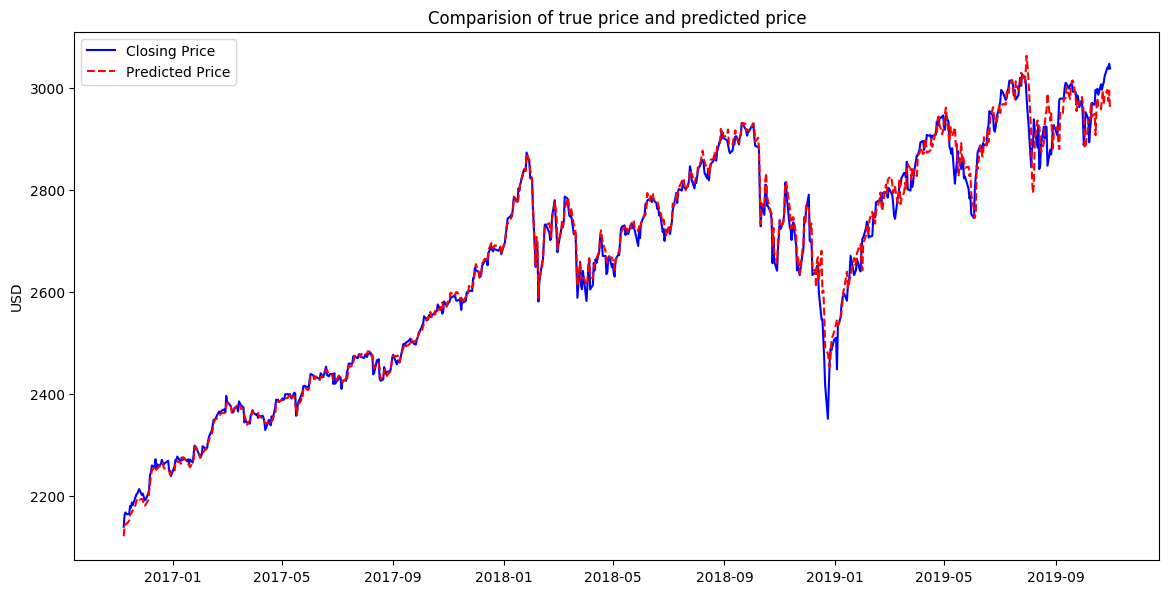

In [0]:
def plot_technical_indicators(dataset, pred_price):
    plt.figure(figsize=(16, 10), dpi=100)
    
#    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index[window:])
    
    # Plot first subplot
#    plt.subplot(2, 1, 1)
    plt.figure(figsize=(14, 7), dpi=100)
    plt.plot(dataset['price'][window:],label='Closing Price', color='b')
    plt.plot(x_, pred_price ,label='Predicted Price', color='r',linestyle='--')
    plt.title('Comparision of true price and predicted price')
    plt.ylabel('USD')
    plt.legend()

    # # Plot second subplot
    # plt.subplot(2, 1, 2)
    # plt.title('MACD')
    # plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    # plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

plot_technical_indicators(df, pred_denorm)

In [0]:
class Auto_exchange():
  def __init__(self):
    self.capital = 10000
    self.remain = 10000
    self.stock = 0
    self.avg = []
    self.small_rate = 0.025
    self.large_rate = 2 * self.small_rate
  def assestment(self):
    return print(self.remain + self.stock * self.true_value[-1] - self.capital)
  def trade(self, y_test, y_pred):
    self.days = len(y_pred)
    self.true_value = y_test
    self.pred_value = y_pred
    for day in range(1, self.days):
      self.diff = self.pred_value[day] - self.pred_value[day-1]
      self.avg.append(abs(self.diff))
      self.threshold = statistics.mean(self.avg)
      if self.diff < 0:
        self.remain, self.stock = self.sell(self.true_value[day], day)
      if self.diff >0:
        self.remain, self.stock = self.buy(self.true_value[day])
      if self.diff == 0:
        pass
      #f"Today is the {day}.th day"
    print("Complete trade")
  def sell(self, true_value, day):
    if self.stock > 0:
      if self.diff >= self.threshold:
        self.remain += self.stock * self.large_rate * true_value
        self.stock = self.stock * (1-self.large_rate)
      else:
        self.remain += self.stock * self.small_rate * true_value
        self.stock = self.stock + (1-self.small_rate)
    else:
      print("Today is day {}, I don't have enough stock".format(day))
    return self.remain, self.stock
  def buy(self, true_value):
    if self.remain >= true_value * self.large_rate:
      if self.diff >= self.threshold:
        self.stock += self.remain * self.large_rate / true_value
        self.remain = self.remain * (1-self.large_rate)
      else:
        self.stock += self.remain * self.small_rate / true_value
        self.remain = self.remain * (1-self.small_rate)
    else:
      print("I am out of money")
    return self.remain, self.stock
      


true_price = df.price[window + y_train.shape[0]:window + y_train.shape[0]+y_test.shape[0]]/100
pred_price = pred_denorm[y_train.shape[0]:y_train.shape[0]+y_test.shape[0]]/100
auto = Auto_exchange()
auto.trade(true_price, pred_price)
auto.assestment()

Today is day 1, I don't have enough stock
Today is day 2, I don't have enough stock
Today is day 3, I don't have enough stock
Complete trade
11841.069776910324
